In [5]:
import os
import numpy
from keras import models, layers, optimizers, losses, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as viz

In [6]:
width = 150
height = 150
rgb = 3
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(width, height, rgb))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
base_dir = '.data/cats_vs_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [8]:
# extract features using VGG

#rescale_factor = 1.0 / 255
batch_size = 20

def extract_features(data_stream, num_samples):
    features = numpy.zeros(shape=(num_samples, 4, 4, 512))
    labels = numpy.zeros(shape=(num_samples))
    sample_count = 0
    for inputs_batch, labels_batch in data_stream:
        features_batch = conv_base.predict(preprocess_input(inputs_batch, mode='tf'), verbose=1)
        features[sample_count : sample_count + batch_size] = features_batch
        labels[sample_count : sample_count + batch_size] = labels_batch
        sample_count += batch_size
        if sample_count >= num_samples:
            break
    return features, labels

In [9]:
data_generator = ImageDataGenerator()
train_stream = data_generator.flow_from_directory(train_dir,
                                                  target_size=(width, height),
                                                  batch_size=batch_size,
                                                  class_mode='binary')
validation_stream = data_generator.flow_from_directory(validation_dir,
                                                       target_size=(width, height),
                                                       batch_size=batch_size,
                                                       class_mode='binary')
test_stream = data_generator.flow_from_directory(test_dir,
                                                 target_size=(width, height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_features, train_labels = extract_features(train_stream, 2000)
validation_features, validation_labels = extract_features(validation_stream, 1000)
test_features, test_labels = extract_features(test_stream, 1000)

# flatten features
train_features = numpy.reshape(train_features, (train_features.shape[0], -1))
validation_features = numpy.reshape(validation_features, (validation_features.shape[0], -1))
test_features = numpy.reshape(test_features, (test_features.shape[0], -1))

20/20 [==============================] - 6s 310ms/step


20/20 [==============================] - 4s 192ms/step


In [19]:
def build_network():
    network = models.Sequential()
    network.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
    network.add(layers.Dropout(0.5))
    network.add(layers.Dense(1, activation='sigmoid'))

    network.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                    loss=losses.binary_crossentropy,
                    metrics=[metrics.binary_accuracy])
    return network

In [12]:
num_epochs = 30
network = build_network()

In [13]:
history = network.fit(train_features, train_labels, epochs=num_epochs, batch_size=20,
                      validation_data=(validation_features, validation_labels)).history

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5222 - binary_accuracy: 0.7385 - val_loss: 0.3100 - val_binary_accuracy: 0.8910
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3218 - binary_accuracy: 0.8650 - val_loss: 0.2412 - val_binary_accuracy: 0.9090
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2434 - binary_accuracy: 0.8945 - val_loss: 0.2172 - val_binary_accuracy: 0.9170
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2051 - binary_accuracy: 0.9130 - val_loss: 0.1990 - val_binary_accuracy: 0.9250
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1801 - binary_accuracy: 0.9255 - val_loss: 0.1946 - val_binary_accuracy: 0.9240
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1658 - binary_accuracy: 0.9385 - val_loss: 0.1823 - val_binary_accuracy: 0.9300
Epoc

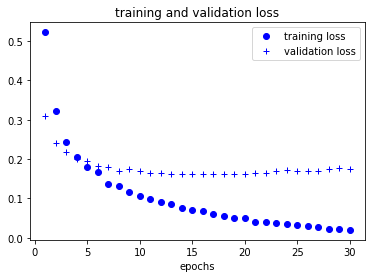

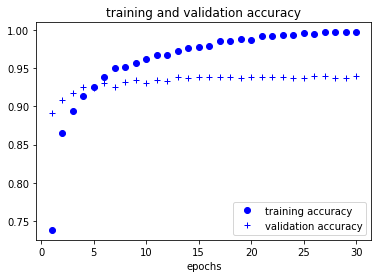

In [14]:
x = range(1, num_epochs + 1)

viz.plot(x, history['loss'], 'bo', label='training loss')
viz.plot(x, history['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()

In [15]:
# extract features with data augmentation
# test and validation streams do not change
train_data_generator = ImageDataGenerator(rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

train_stream = train_data_generator.flow_from_directory(train_dir,
                                                        target_size=(width, height),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [16]:
# 3 augmented images per each from 2000 original images
train_features, train_labels = extract_features(train_stream, 8000)
validation_features, validation_labels = extract_features(validation_stream, 1000)
test_features, test_labels = extract_features(test_stream, 1000)

# flatten features
train_features = numpy.reshape(train_features, (train_features.shape[0], -1))
validation_features = numpy.reshape(validation_features, (validation_features.shape[0], -1))
test_features = numpy.reshape(test_features, (test_features.shape[0], -1))

20/20 [==============================] - 4s 193ms/step


20/20 [==============================] - 4s 195ms/step


20/20 [==============================] - 4s 196ms/step


20/20 [==============================] - 4s 196ms/step


In [20]:
network = build_network()
history_augmented = network.fit(train_features, train_labels, epochs=num_epochs, batch_size=20,
                                validation_data=(validation_features, validation_labels)).history

Train on 8000 samples, validate on 1000 samples
Epoch 1/30
8000/8000 [==============================] - 15s 2ms/step - loss: 0.4658 - binary_accuracy: 0.7706 - val_loss: 0.2224 - val_binary_accuracy: 0.9100
Epoch 2/30
8000/8000 [==============================] - 16s 2ms/step - loss: 0.3131 - binary_accuracy: 0.8636 - val_loss: 0.1933 - val_binary_accuracy: 0.9200
Epoch 3/30
8000/8000 [==============================] - 16s 2ms/step - loss: 0.2656 - binary_accuracy: 0.8782 - val_loss: 0.1774 - val_binary_accuracy: 0.9270
Epoch 4/30
8000/8000 [==============================] - 15s 2ms/step - loss: 0.2386 - binary_accuracy: 0.8995 - val_loss: 0.1732 - val_binary_accuracy: 0.9390
Epoch 5/30
8000/8000 [==============================] - 15s 2ms/step - loss: 0.2167 - binary_accuracy: 0.9119 - val_loss: 0.1698 - val_binary_accuracy: 0.9390
Epoch 6/30
8000/8000 [==============================] - 15s 2ms/step - loss: 0.2004 - binary_accuracy: 0.9200 - val_loss: 0.1686 - val_binary_accuracy: 0.939

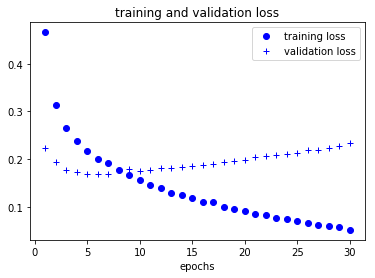

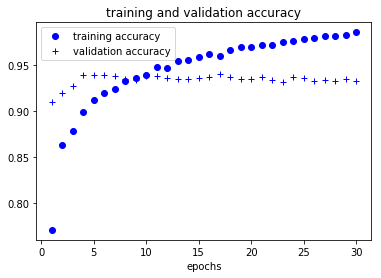

In [21]:
x = range(1, num_epochs + 1)

viz.plot(x, history_augmented['loss'], 'bo', label='training loss')
viz.plot(x, history_augmented['val_loss'], 'b+', label='validation loss')
viz.title('training and validation loss')
viz.xlabel('epochs')
viz.legend()

viz.figure()

viz.plot(x, history_augmented['binary_accuracy'], 'bo', label='training accuracy')
viz.plot(x, history_augmented['val_binary_accuracy'], 'b+', label='validation accuracy')
viz.title('training and validation accuracy')
viz.xlabel('epochs')
viz.legend()

viz.show()